In [1]:
# configure plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm

%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

%matplotlib inline

#dark plotting
plt.style.use('dark_background')

In [2]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
import numpy as np
import pandas as pd

# Reading vibrometer outputs

In [4]:
import os
import glob
import natsort
import numpy as np

In [5]:
def load_vibrometer_scan(path,extension):
    "this function takes a vibrometer output text file and creates a"
    "complex-valued array of the fft. also mirrors these data for proper formatting to ifft functions"
    
    #loading files names
    os.chdir(path)
    file_names = []
    
    for name in glob.glob(extension):
        file_names.append(name)
        
    file_names = natsort.natsorted(file_names, reverse=False)

###############################################################################
    magnitude = [[] for _ in range(len(file_names))]
    phase = [[] for _ in range(len(file_names))]
    fbins = [[] for _ in range(len(file_names))]

    for scan_pt in range(len(file_names)):

        #loading a .txt file, only the numerical data and not the header info
        scan_pt_temp = np.loadtxt(file_names[scan_pt],skiprows = 7, encoding='windows-1252') 
        
        #swapping axes so that data are ordered by columns
        scan_pt_temp = np.swapaxes(scan_pt_temp,0,1) 
        
        #making a magnitude vector
        magnitude[scan_pt] = scan_pt_temp[1]

        #making a phase vector
        phase[scan_pt] = scan_pt_temp[2] 
    
        fbins[scan_pt] = scan_pt_temp[0] 
###############################################################################    
    #i suppose i could retrieve the complex, un-mirrored fft -- but for now the ifft is important so i will take only the mirrored
    return np.asarray(fbins),np.asarray(magnitude),np.asarray(phase)

In [6]:
path ='/Volumes/Extreme Pro/Projects/Vibrometer/Data/2024_04/SoundSpeed/6kHz_txt/'
extension = '6kHz_*.txt'

In [7]:
#loading files names
os.chdir(path)
file_names = []

for name in glob.glob(extension):
    file_names.append(name)
    
file_names = natsort.natsorted(file_names, reverse=False)

x = []
y = []

for scan_pt in range(len(file_names)):

    df = pd.read_csv(file_names[scan_pt],
                                skipinitialspace=True,
                                delimiter='\t',
                                skiprows=1,
                                skip_blank_lines=True,encoding='windows-1252',names=['frequency', 'magnitude', 'phase','x','y','z'])
    
    x_temp = df['phase'][0]
    x_temp = x_temp.replace('[x = ', '')#removing extraneous characters from the cells
    x_temp = float(x_temp)
    x.append(x_temp)
    
    y_temp = df['x'][0]
    y_temp = y_temp.replace('y = ', '')
    y_temp = float(y_temp)
    y.append(y_temp)

y_scaled = y + abs(np.min(y)) # removing negative value

# Loading data

In [21]:
path ='/Volumes/Extreme Pro/Projects/Vibrometer/Data/2024_04/SoundSpeed/5kHz_txt/'
extension = '5kHz_*.txt'

In [22]:
fbins,magnitude,phase = load_vibrometer_scan(path,extension)

frequency = 5000

arg = np.argwhere(fbins[0] == frequency) #the index of the 2kHz bin
arg = int(arg)

T = 1/1e3 #1/f, the period
t = np.linspace(0,2*np.pi,frequency) #time/angle vector

In [23]:
waves = [[] for _ in range(fbins.shape[0])]

f = frequency #the frequency of interest

for scan_pt in range(fbins.shape[0]):

    A = magnitude[scan_pt][arg] #the magnitude at frequency, in mm/s
    phi = phase[scan_pt][arg] #the phase at frequency, in degrees
    phi = np.deg2rad(phi) #converting to radians
    
    waves[scan_pt] = A*np.sin(t * f + phi) #generating the waveform

waves = np.asarray(waves)

## Inspecting a single waveform

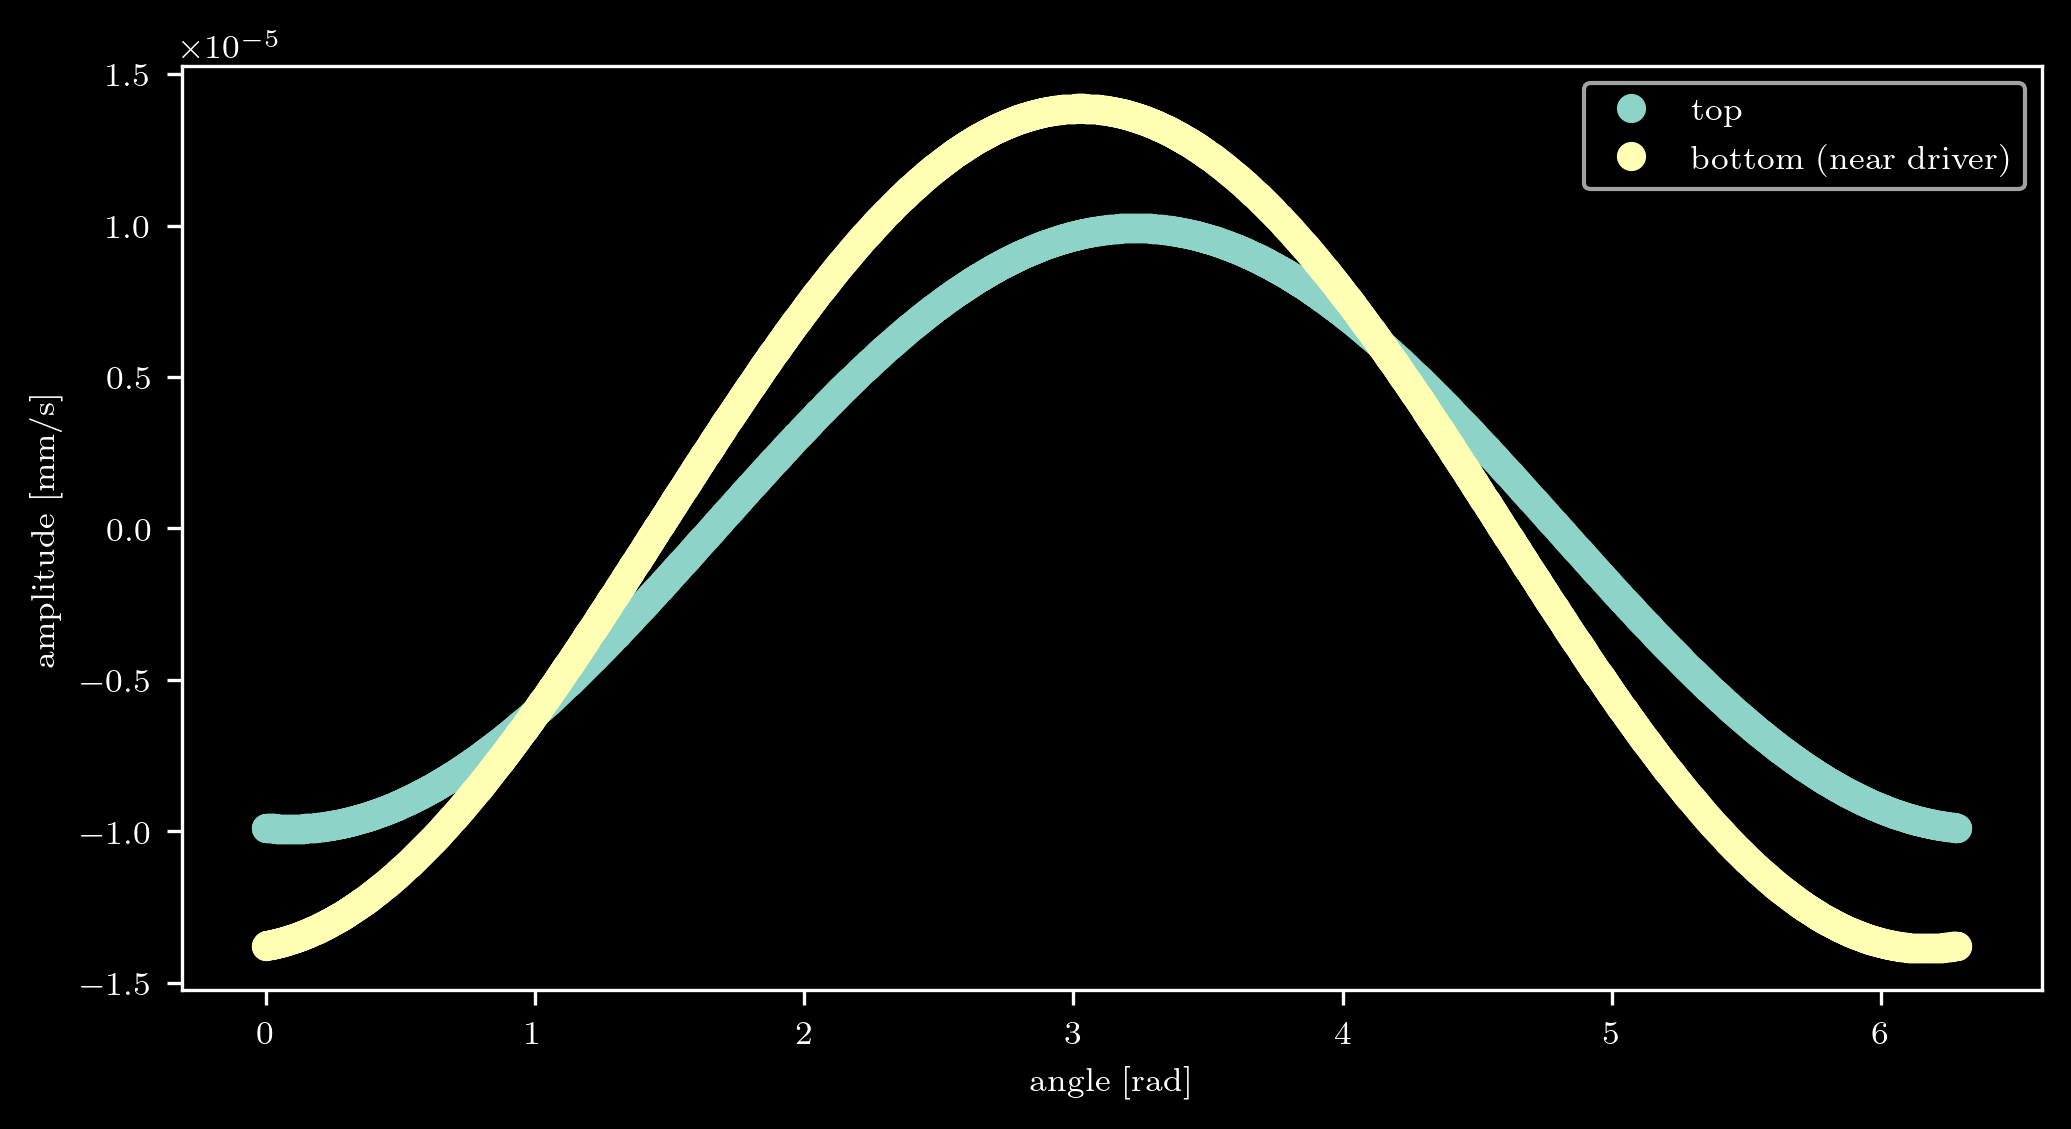

In [24]:
fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(111)

ax1.plot(t,waves[0],'o',label = 'top')
ax1.plot(t,waves[322],'o',label = 'bottom (near driver)')

ax1.set_ylabel('amplitude [mm/s]')
ax1.set_xlabel('angle [rad]')

ax1.legend()

In [27]:
x_grid = np.linspace(0,1/frequency,frequency) #grid spacing in seconds
y_grid = np.linspace(np.max(y_scaled),np.min(y_scaled),waves.shape[0]) #grid spacing in m

x_grid = x_grid *1e6 #converting from s to \mu s
y_grid = y_grid *1e3 #converting from m to mm

meshgrid = np.meshgrid(x_grid,y_grid)
xx,yy = np.asarray(meshgrid)

# xx = np.fliplr(xx)
yy = np.fliplr(yy)

In [33]:
0.06 / 6e-3

10.0

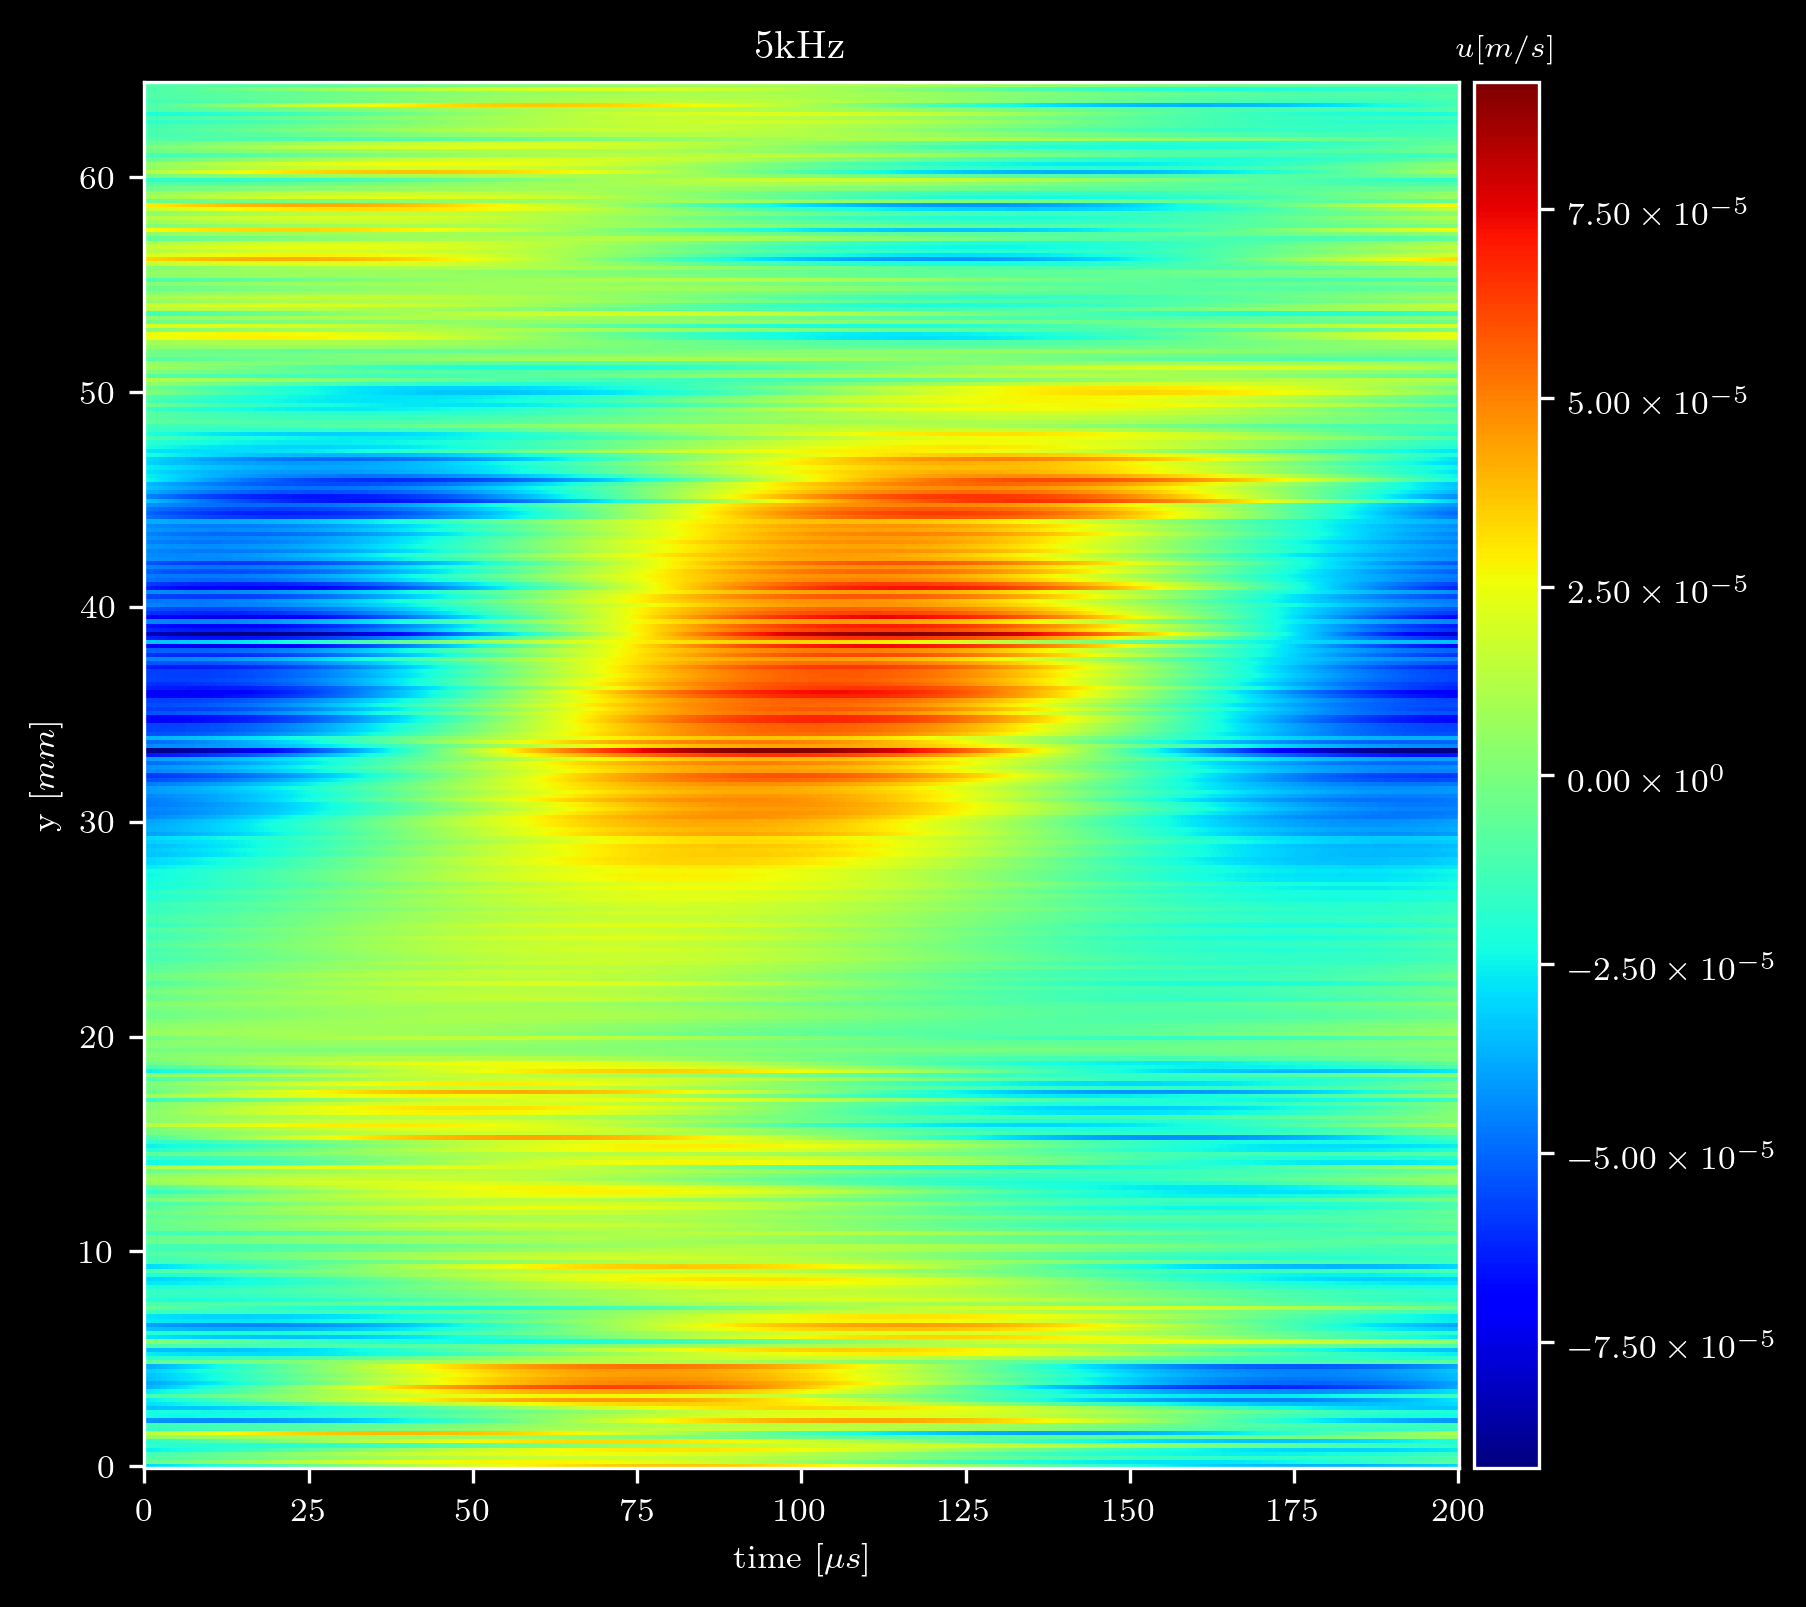

In [29]:
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111)

vmin = -1e-6
vmax = 1e-6

im = ax.pcolormesh(xx,yy,waves,cmap = 'jet',shading='nearest')#,vmin = vmin,vmax = vmax)

ax.set_title('5kHz')
# ax.set_xlabel(r'time [$\mu s$]')
# ax.set_ylabel(r'depth [mm]')

ax.set_xlabel(r'time [$ \mu s$]')
ax.set_ylabel(r'y [$mm$]')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cax.set_title(r'$u [m/s]$',fontsize = 7)
fig.colorbar(im, cax=cax, orientation='vertical',format=ticker.FuncFormatter(fmt))

# plt.savefig("/Volumes/Extreme Pro/Projects/Vibrometer/Figures/space-time_5kHz" + ".jpg",format="JPG",bbox_inches='tight')

In [15]:
# dividing the sound speeds by the frequency to measure a wavelength

a =  200 / 1000
b =  171 / 2000
c =  200 / 3000
d =  300 / 4000
e =  600 / 5000

In [16]:
a,b,c,d,e

(0.2, 0.0855, 0.06666666666666667, 0.075, 0.12)

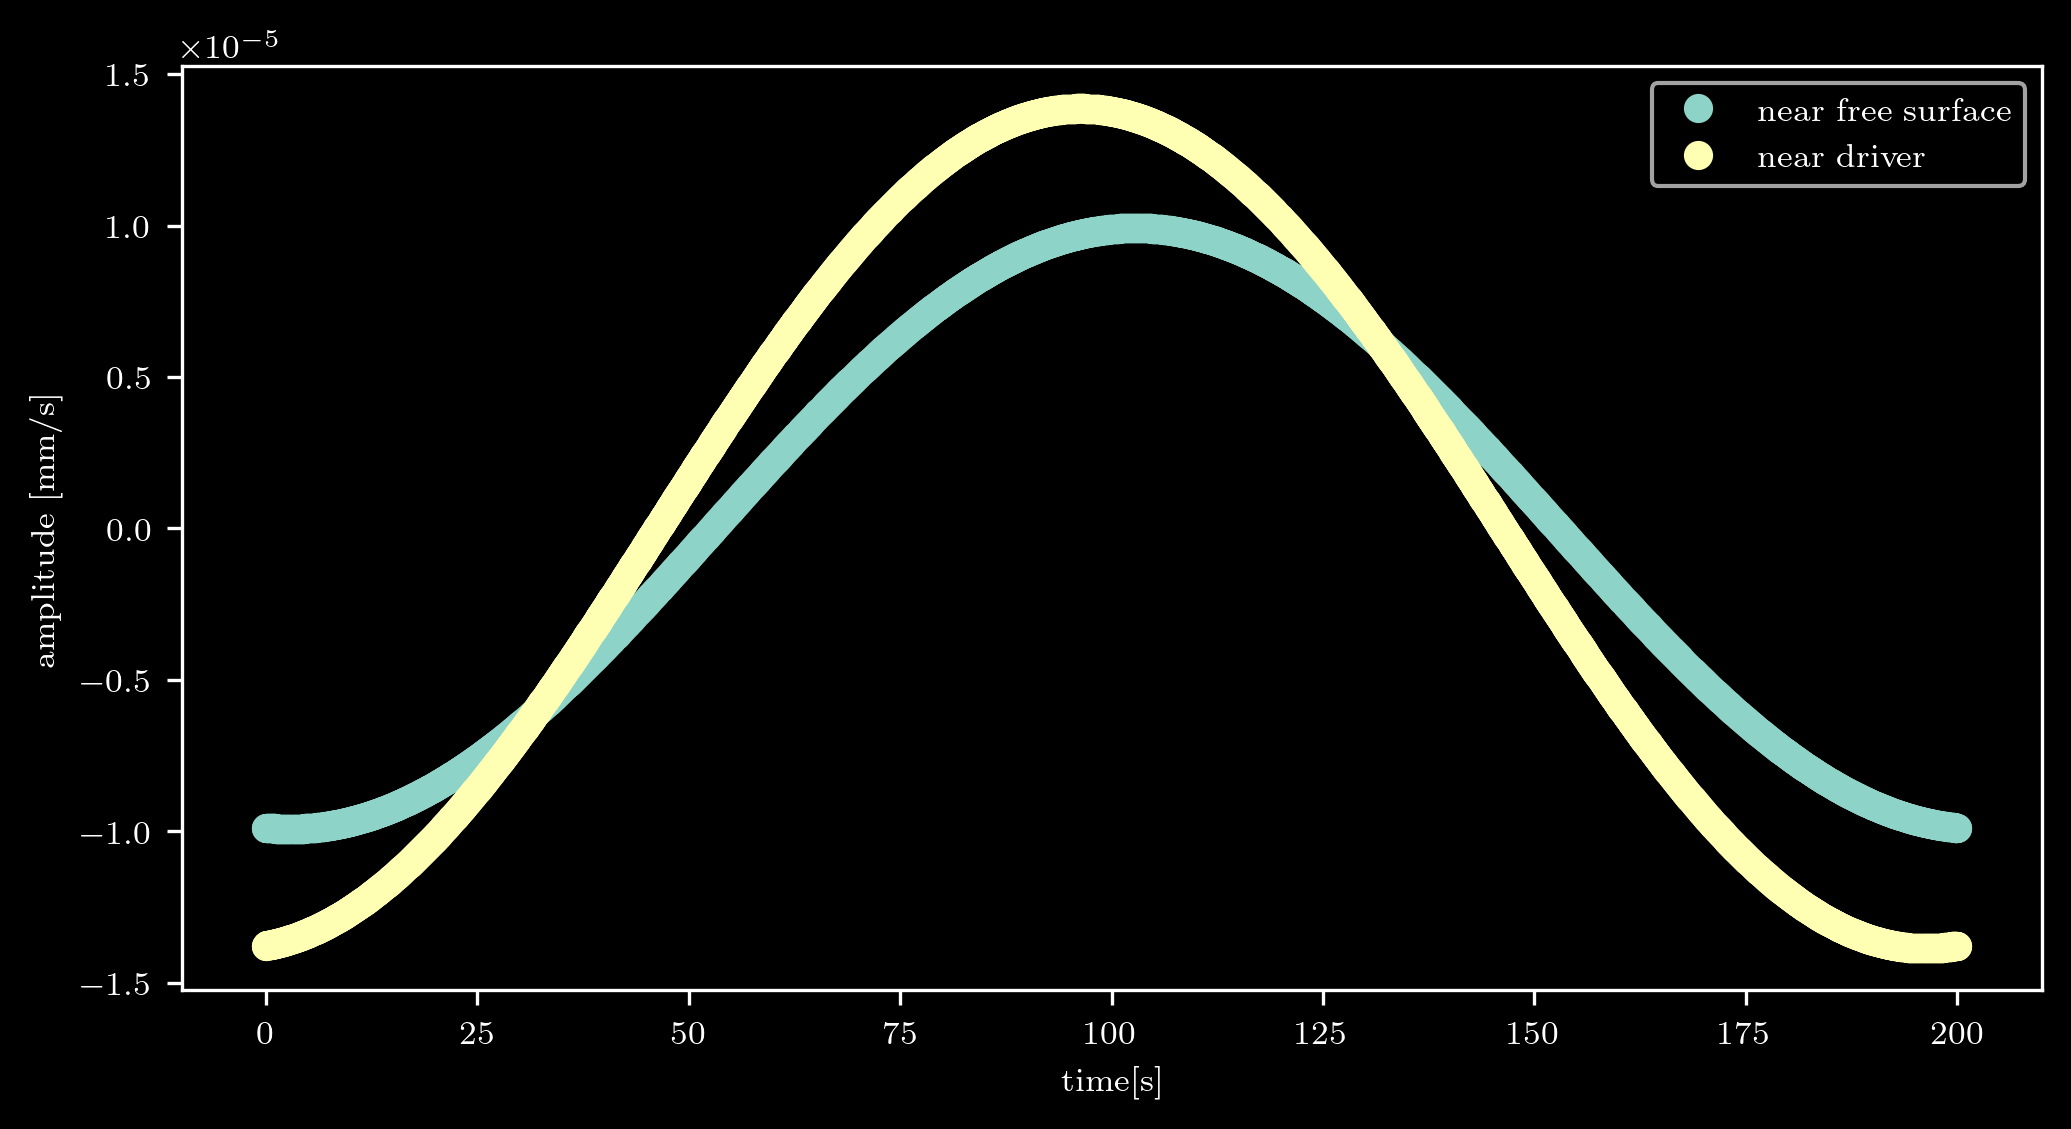

In [30]:
fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(111)

ax1.plot(x_grid,waves[0],'o',label = 'near free surface')
ax1.plot(x_grid,waves[322],'o',label = 'near driver')

ax1.set_ylabel('amplitude [mm/s]')
ax1.set_xlabel('time[s]')

ax1.legend()

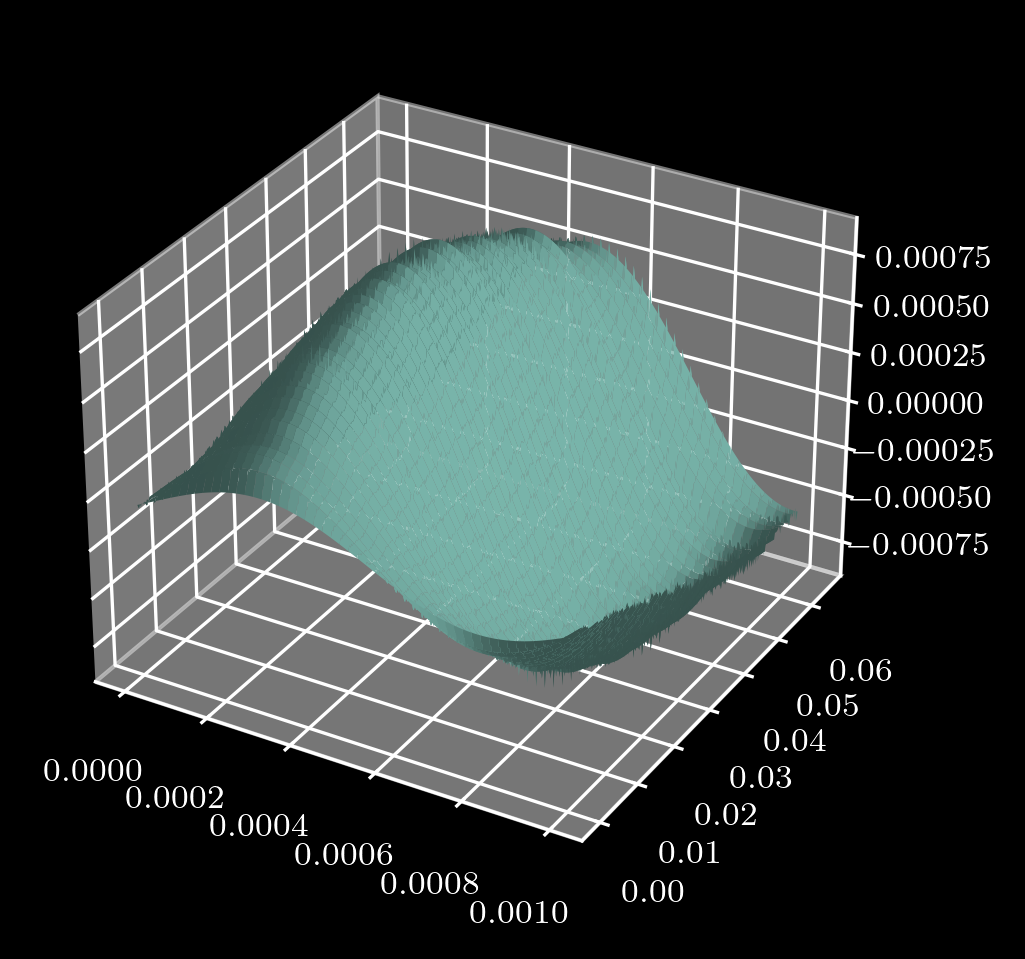

In [14]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx,yy,waves,linewidth=2)#, rstride=10, cstride=10)

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(x,y)
ax2.plot(x,y_new)

In [ ]:
# ## more than one

# color=iter(cm.viridis(np.linspace(0,1,139)))
# c=next(color)

    
# fig = plt.figure(figsize=(8, 4))
# ax1 = plt.subplot(111)

# for scan_pt in range(len(file_names)):
#     c=next(color)
#     ax1.plot(t,waves[scan_pt],color = 'c')

# ax1.set_ylabel('amplitude [mm/s]')
# ax1.set_xlabel('angle [rad]')